In [61]:
import pandas as pd

from orion.data import load_signal

# 1. Data

In [73]:
reference_time = pd.Timestamp('2024-01-01 00:00:00')
data = pd.read_csv("/Users/coloner/IdeaProjects/ml/Orion/data/TimeSeries.csv")

data['timestamp'] = pd.to_datetime(data.index, unit='s', origin=reference_time)


print(data.head())
print(type(data))

     v1    v2     v3   v4   v5   v6     v7     v8     v9    v10    v11  \
0 -2.00  1.51  10.14  0.0  0.0  0.0 -15.78 -22.31 -11.70 -13.57  92.95   
1 -2.00  1.51  10.13  0.0  0.0  0.0 -16.86 -23.38 -10.31 -13.57  92.95   
2 -2.00  1.51  10.13  0.0  0.0  0.0 -16.86 -23.38 -10.31 -13.57  92.95   
3 -1.99  1.51  10.17  0.0  0.0  0.0 -16.86 -23.38 -10.31 -13.57  92.95   
4 -1.99  1.51  10.17  0.0  0.0  0.0 -16.86 -23.38 -10.31 -13.57  92.95   

            timestamp  
0 2024-01-01 00:00:00  
1 2024-01-01 00:00:01  
2 2024-01-01 00:00:02  
3 2024-01-01 00:00:03  
4 2024-01-01 00:00:04  
<class 'pandas.core.frame.DataFrame'>


In [163]:
a = ("a", "b", "c", "d", "e", "f", "g", "h")
x = slice(1)
print(a[x])

('a',)


In [164]:
import numpy as np

# Example array (3D)
X = np.arange(3 * 4 * 5).reshape((3, 4, 5))
print(X)

# Parameters
target_index = 2
axis = 1

# Function execution
if isinstance(target_index, int):
    target_index = [target_index]

dims = len(X.shape)
if axis >= (dims):
    raise ValueError("Axis {} is outside the dimensions of X ({}).".format(axis, dims))

indices = [slice(None)] * dims
indices[axis] = target_index
print(indices)

result = X[tuple(indices)].copy()
print(result)

[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]
  [30 31 32 33 34]
  [35 36 37 38 39]]

 [[40 41 42 43 44]
  [45 46 47 48 49]
  [50 51 52 53 54]
  [55 56 57 58 59]]]
[slice(None, None, None), [2], slice(None, None, None)]
[[[10 11 12 13 14]]

 [[30 31 32 33 34]]

 [[50 51 52 53 54]]]


In [74]:
data.columns.get_loc('v1')

0

In [118]:
data.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,timestamp
0,-2.00,1.51,10.14,0.0,0.0,0.0,-15.78,-22.31,-11.70,-13.57,92.95,1704067200
1,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95,1704067201
2,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95,1704067202
3,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95,1704067203
4,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95,1704067204


In [76]:
(data.loc[1,'timestamp'] - data.loc[0,'timestamp']).total_seconds()

1.0

In [90]:
data['timestamp'] = data['timestamp'].view('int64') 

In [98]:
data['timestamp'] = data['timestamp'].astype('int64')

In [100]:
data.shape

(509632, 12)

# 2. Pipeline

In [79]:
from mlblocks import MLPipeline

pipeline_name = 'aer'

pipeline = MLPipeline(pipeline_name)

In [101]:
hyperparameters = {
    "mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1": {
        'interval': 1
    },
    "mlstars.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        'target_column': 0
    },
    'orion.primitives.aer.AER#1': {
        'epochs': 5,
        'verbose': True
    }
}
pipeline.set_hyperparameters(hyperparameters)

## step by step execution

MLPipelines are compose of a squence of primitives, these primitives apply tranformation and calculation operations to the data and updates the variables within the pipeline. To view the primitives used by the pipeline, we access its `primtivies` attribute. 

The `lstm_dynamic_threshold` contains 7 primitives. we will observe how the `context` (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [85]:
pipeline.primitives

['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'sklearn.preprocessing.MinMaxScaler',
 'mlstars.custom.timeseries_preprocessing.rolling_window_sequences',
 'orion.primitives.timeseries_preprocessing.slice_array_by_dims',
 'orion.primitives.aer.AER',
 'orion.primitives.aer.score_anomalies',
 'orion.primitives.timeseries_anomalies.find_anomalies']

### time segments aggregate
this primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    - `X` sequence of aggregated values, one column for each aggregation method.
    - `index` sequence of index values (first index of each aggregated segment).

In [116]:
len(context['index'])

509632

In [115]:
context = pipeline.fit(data, output_=0) 
context.keys()

dict_keys(['X', 'index'])

In [123]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1704067200 has value [[ -2.     1.51  10.14 ... -11.7  -13.57  92.95]
 [ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
 [ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
 ...
 [ -2.02   1.51  10.14 ... -12.56 -13.62  92.97]
 [ -2.02   1.51  10.14 ... -12.56 -13.62  92.96]
 [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]]
entry at 1704067201 has value [[ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
 [ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
 [ -1.99   1.51  10.17 ... -10.31 -13.57  92.95]
 ...
 [ -2.02   1.51  10.14 ... -12.56 -13.62  92.96]
 [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]
 [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]]
entry at 1704067202 has value [[ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
 [ -1.99   1.51  10.17 ... -10.31 -13.57  92.95]
 [ -1.99   1.51  10.17 ... -10.31 -13.57  92.95]
 ...
 [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]
 [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]
 [ -2.     1.52  10.15 ... -11.18 -13.64  92.96]]
entry at 1

### SimpleImputer
this primitive is an imputation transformer for filling missing values.
* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `X` which is a transformed version of X.

In [119]:
step = 1

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

/Users/coloner/IdeaProjects/ml/Orion/venv/lib/python3.9/site-packages/sklearn/impute/_base.py:356: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


dict_keys(['index', 'X'])

### MinMaxScaler
this primitive transforms features by scaling each feature to a given range.
* **input**: `X` the data used to compute the per-feature minimum and maximum used for later scaling along the features axis.
* **output**: `X` which is a transformed version of X.

In [32]:
step = 2

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X'])

In [33]:
# after scaling the data between [-1, 1]
# in this example, no change is observed
# since the data was pre-handedly scaled

for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [-0.36635895]
entry at 1222840800 has value [-0.39410778]
entry at 1222862400 has value [0.4036246]
entry at 1222884000 has value [-0.36275906]
entry at 1222905600 has value [-0.37074649]


### rolling window sequence
this primitive generates many sub-sequences of the original sequence. it uses a rolling window approach to create the sub-sequences out of time series data.

* **input**: 
    - `X` n-dimensional sequence to iterate over.
    - `index` array containing the index values of X.
* **output**:
    - `X` input sequences.
    - `y` target sequences.
    - `index` first index value of each input sequence.
    - `target_index` first index value of each target sequence.

In [121]:
step = 3

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X', 'y', 'X_index', 'y_index'])

In [129]:
# after slicing X into multiple sub-sequences
# we obtain a 3 dimensional matrix X where
# the shape indicates (# slices, window size, 1)
# and similarly y is (# slices, target size)

print("X shape = {}\ny shape = {}\nX index shape = {}\ny index shape = {}".format(
    context['X'].shape, context['y'].shape, context['index'].shape, context['y_index'].shape))

print("X shape = {}\ny shape = {}\nX index shape = {}\ny index shape = {}".format(
    context['X'][:5], context['y'][:5], context['index'][:5], context['y_index'][:5]))


y_ = context['y'].copy() # make a copy to copare later

X shape = (509532, 100, 11)
y shape = (509532, 100, 1)
X index shape = (509632,)
y index shape = (509532,)
X shape = [[[ -2.     1.51  10.14 ... -11.7  -13.57  92.95]
  [ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
  [ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
  ...
  [ -2.02   1.51  10.14 ... -12.56 -13.62  92.97]
  [ -2.02   1.51  10.14 ... -12.56 -13.62  92.96]
  [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]]

 [[ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
  [ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
  [ -1.99   1.51  10.17 ... -10.31 -13.57  92.95]
  ...
  [ -2.02   1.51  10.14 ... -12.56 -13.62  92.96]
  [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]
  [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]]

 [[ -2.     1.51  10.13 ... -10.31 -13.57  92.95]
  [ -1.99   1.51  10.17 ... -10.31 -13.57  92.95]
  [ -1.99   1.51  10.17 ... -10.31 -13.57  92.95]
  ...
  [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]
  [ -2.02   1.5   10.14 ... -12.56 -13.63  92.96]
  [ -2.    

### slice array by dims

this primitive selects a particular channel from `X` to try and reconstruct / predict it.

* **input**:
    * `X` n-dimensional array containing the input sequences.
    * `target_index` which index from `X` to slice out.
* **output**:
    * `y` 1-dimenstional array containing the target sequences.

In [127]:
step = 4

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X_index', 'y_index', 'X', 'y'])

In [128]:
context[]

dict_keys(['index', 'X_index', 'y_index', 'X', 'y'])

### AER
this is a hybrid prediction and reconstruction model using LSTM layers. you can read more about it in the [related paper](https://arxiv.org/pdf/2212.13558).

* **input**: 
    - `X` n-dimensional array containing the input sequences for the model.
    - `y` n-dimensional array containing the target sequences for the model.
* **output**: `y_hat` predicted values.

In [130]:
step = 5

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

Epoch 1/5
6370/6370 [==============================] - 295s 46ms/step - loss: 2.8724 - tf.__operators__.getitem_loss: 2.6506 - tf.__operators__.getitem_1_loss: 3.1234 - tf.__operators__.getitem_2_loss: 2.5920 - val_loss: 15.3035 - val_tf.__operators__.getitem_loss: 12.0283 - val_tf.__operators__.getitem_1_loss: 16.1838 - val_tf.__operators__.getitem_2_loss: 16.8181
Epoch 2/5
6370/6370 [==============================] - 282s 44ms/step - loss: 2.3969 - tf.__operators__.getitem_loss: 1.9457 - tf.__operators__.getitem_1_loss: 2.8618 - tf.__operators__.getitem_2_loss: 1.9183 - val_loss: 22.9757 - val_tf.__operators__.getitem_loss: 11.3338 - val_tf.__operators__.getitem_1_loss: 27.6961 - val_tf.__operators__.getitem_2_loss: 25.1769
Epoch 3/5
6370/6370 [==============================] - 282s 44ms/step - loss: 2.3218 - tf.__operators__.getitem_loss: 1.8110 - tf.__operators__.getitem_1_loss: 2.8198 - tf.__operators__.getitem_2_loss: 1.8366 - val_loss: 23.4988 - val_tf.__operators__.getitem_loss

dict_keys(['index', 'X_index', 'y_index', 'X', 'y', 'ry_hat', 'y_hat', 'fy_hat'])

In [135]:
ry, fy = context['y'][:, 0], context['y'][:, -1]

for i, y, y_hat in list(zip(context['y_index'], fy, context['fy_hat']))[-20:]:
    print("entry at {} has value {}, predicted value {}".format(i, y, y_hat))

entry at 1704576812 has value [-8.26], predicted value [-7.108035]
entry at 1704576813 has value [-8.25], predicted value [-7.100478]
entry at 1704576814 has value [-8.25], predicted value [-7.0678062]
entry at 1704576815 has value [-8.2], predicted value [-7.07265]
entry at 1704576816 has value [-8.2], predicted value [-7.048071]
entry at 1704576817 has value [-8.23], predicted value [-7.161743]
entry at 1704576818 has value [-8.23], predicted value [-7.1578693]
entry at 1704576819 has value [-8.27], predicted value [-7.1669884]
entry at 1704576820 has value [-8.27], predicted value [-7.1837893]
entry at 1704576821 has value [-8.28], predicted value [-7.179118]
entry at 1704576822 has value [-8.28], predicted value [-7.185335]
entry at 1704576823 has value [-8.25], predicted value [-7.227417]
entry at 1704576824 has value [-8.25], predicted value [-7.342127]
entry at 1704576825 has value [-8.24], predicted value [-7.0781]
entry at 1704576826 has value [-8.24], predicted value [-7.2181

### score anomalies

this primitive computes an array of errors comparing predictions and expected output.

* **input**: 
    - `y` ground truth.
    - `y_hat` reconstructed values.
    - `fy_hat` forward prediction values.
    - `ry_hat` reverse prediction values.
* **output**: `errors` array of errors.

In [132]:
step = 6

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X_index', 'y_index', 'ry_hat', 'y_hat', 'fy_hat', 'X', 'y', 'errors'])

In [136]:
for i, e in list(zip(context['y_index'], context['errors']))[:5]:
    print("entry at {} has error value {:.3f}".format(i, e))

entry at 1704067300 has error value 1.000
entry at 1704067301 has error value 1.001
entry at 1704067302 has error value 1.001
entry at 1704067303 has error value 1.001
entry at 1704067304 has error value 1.001


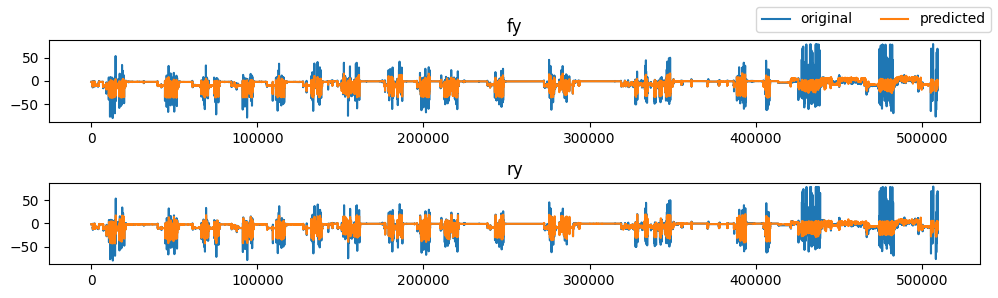

In [137]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 3))

ax1, ax2 = axs
ax1.plot(fy, label='original')
ax1.plot(context['fy_hat'], label='predicted')
ax1.set_title('fy')

ax2.plot(ry, label='original')
ax2.plot(context['ry_hat'], label='predicted')
ax2.set_title('ry')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, ncols=2, loc='upper right')
plt.tight_layout()
plt.show();

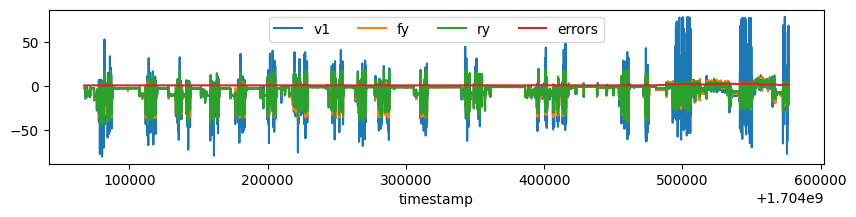

In [139]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 2))
ax = fig.gca()

t = data['timestamp'].values

data.plot(x='timestamp', y='v1', ax=ax)
plt.plot(t[100:], context['fy_hat'], label='fy')
plt.plot(t[:-100], context['ry_hat'], label='ry')

plt.plot(t[:-1], context['errors'], label='errors')
plt.legend(ncols=4)

plt.show();

### find anomalies
this primitive extracts anomalies from sequences of errors following the approach explained in the [related paper](https://arxiv.org/pdf/1802.04431.pdf).

* **input**: 
    - `errors` array of errors.
    - `target_index` array of indices of errors.
* **output**: `y` array containing start-index, end-index, score for each anomalous sequence that was found.

In [140]:
step = 7

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X_index', 'y_index', 'ry_hat', 'y_hat', 'fy_hat', 'errors', 'X', 'y'])

In [142]:
context['y']

array([[1.70445987e+09, 1.70446037e+09, 4.39722374e-01],
       [1.70446075e+09, 1.70446122e+09, 6.53210229e-01],
       [1.70447345e+09, 1.70447408e+09, 5.83889392e-01]])

In [144]:
df = pd.DataFrame(context['y'], columns=['start', 'end', 'severity'])
df['start'] = df['start'].astype('int64')
df['end'] = df['end'].astype('int64')
df

,start,end,severity
0,1704459870,1704460374,0.439722
1,1704460752,1704461223,0.653210
2,1704473450,1704474076,0.583889


In [148]:
pipeline.save("/Users/coloner/IdeaProjects/ml/Orion/data/model")